# `jax.lax.scan` Tutorial

How to use the scan primitive to eliminate Python for-loops when unrolling trajectories.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("dark_background")

In [2]:
class KS_ETDRK2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

In [3]:
DOMAIN_SIZE = 100.0
N_DOF = 200
DT = 0.5

ks_stepper = KS_ETDRK2(
    L=DOMAIN_SIZE,
    N=N_DOF,
    dt=DT,
)
ks_stepper = jax.jit(ks_stepper)

u_0 = jax.random.normal(jax.random.PRNGKey(0), (N_DOF,))

u_current = u_0
trj = [u_current, ]
for i in range(2000):
    u_current = ks_stepper(u_current)
    trj.append(u_current)

trj = jnp.stack(trj)

Text(0, 0.5, 'space')

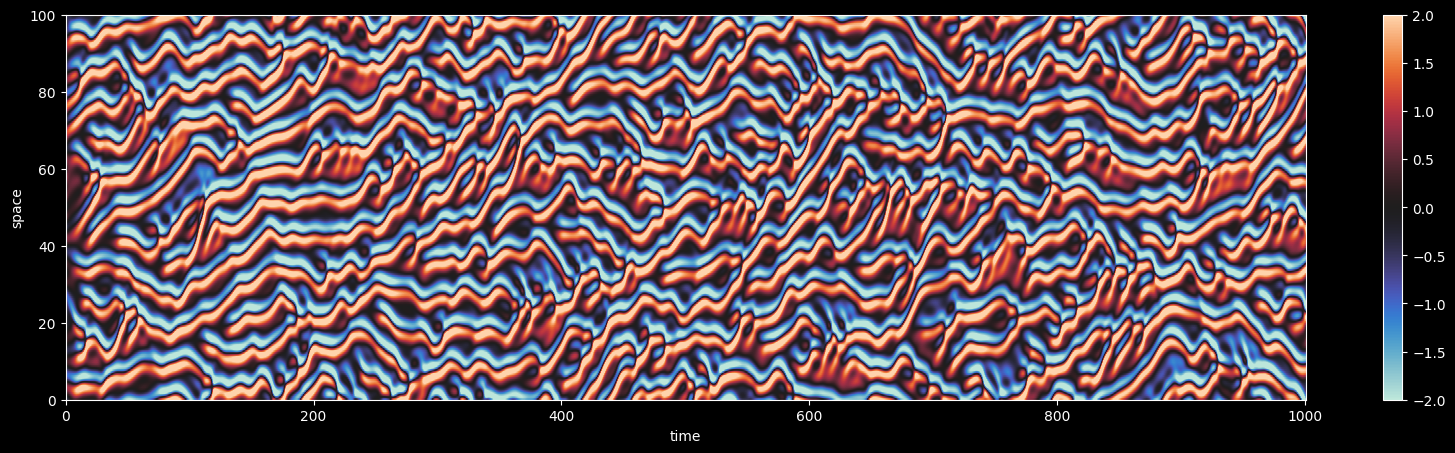

In [4]:
plt.figure(figsize=(20, 5))
plt.imshow(
    trj.T,
    cmap="icefire",
    aspect="auto",
    origin="lower",
    extent=(0, trj.shape[0] * DT, 0, 100),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")

In [ ]:
# scan_fn:  State x Force/Control  ->  new_State x Observation

# (x, u) -> (x, y)

In [8]:
def scan_fn(u, _):
    u_next = ks_stepper(u)
    return u_next, u_next

final_state, trj = jax.lax.scan(
    scan_fn,
    u_0,
    None,
    length=2000,
)

Text(0, 0.5, 'space')

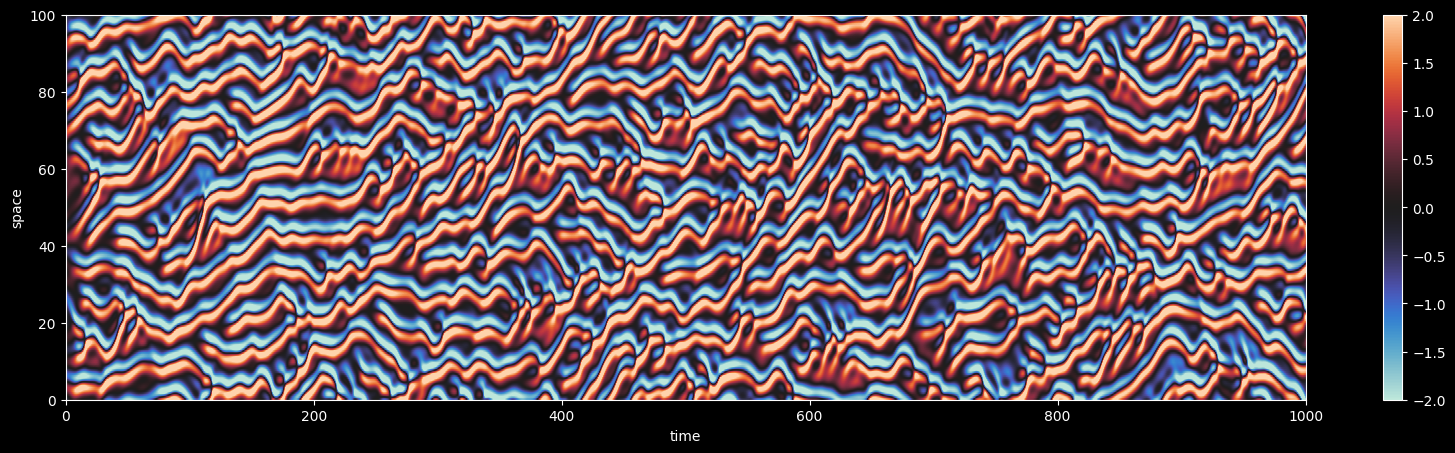

In [9]:
plt.figure(figsize=(20, 5))
plt.imshow(
    trj.T,
    cmap="icefire",
    aspect="auto",
    origin="lower",
    extent=(0, trj.shape[0] * DT, 0, 100),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")